## Import lib

In [198]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from collections import Counter, OrderedDict
from matplotlib import cm
from matplotlib import colors as col
from IPython import display
from IPython.display import HTML as html_print
from tqdm import trange, tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

## Upload dataset

In [199]:
path = "data_etsy.csv"
df = pd.read_csv(path, dtype=str).drop('Unnamed: 0', axis=1)
df = df.dropna().astype(str)

In [200]:
print("Max length of article:", df['description'].str.len().max())

Max length of article: 11784


## Generate vocabulary

In [4]:
%%time
vocabulary, counts = np.unique(bytearray(''.join(df['description']).encode('unicode-escape')), return_counts=True)
n_letters = len(vocabulary)

print("Length of vocabulary:", len(vocabulary))
print("Vocabulary:", bytearray(vocabulary).decode('unicode-escape'), '\n')

Length of vocabulary: 92


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: invalid escape sequence '\]'
  """


Vocabulary:  !"#$%&()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ 

Wall time: 115 ms


## OneHotEncode of the data and transform to the tensor

In [5]:
# article -> tensor

import torch

id2char = dict(enumerate(bytearray(vocabulary).decode('unicode-escape')))
char2id = {tok: i for (i, tok) in id2char.items()}

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(n_letters, dtype=torch.long)
    tensor[char2id.get(letter, 0)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line, lenght): 
    indeces = []
    for li, letter in enumerate(line):
        indeces += [[li + lenght - len(line), char2id.get(letter, 0)]]
    return torch.sparse_coo_tensor(np.array(indeces).T,
                                   torch.ones(len(indeces)),
                                   size=(lenght, n_letters)).to_dense()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: invalid escape sequence '\]'
  """


## DataLoader

In [6]:
#Change class name 
class DataLoader(Dataset):
    def __init__(self, texts, max_len=100):
        self.texts = texts
        self.max_len = max_len

    def __getitem__(self, idx):
        pos = np.random.randint(0, len(self.texts[idx]) - 1)
        x = self.texts[idx][pos: pos + self.max_len]
        
        y = torch.zeros(self.max_len - 1, dtype=torch.long)
        for k, ch in enumerate(x[1:]):
            y[k + self.max_len - 1 - len(x[1:])] = char2id.get(ch, 0)
        return lineToTensor(x[:-1], self.max_len - 1), y
    
    def __len__(self): 
        return (len(self.texts))

## Model architecture 

In [7]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.rnn = nn.RNN(vocab_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        out, hidden = self.rnn(input, hidden)
        out = self.decoder(out)
        return out.permute(0, 2, 1)
    
    def get_params(self):
        return (self.rnn._parameters['weight_ih_l0'],
                self.rnn._parameters['weight_hh_l0'],
                self.rnn._parameters['bias_ih_l0'],
                self.rnn._parameters['bias_hh_l0'])

## Initialize the model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, n_letters).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)

cuda:0


In [9]:
BATCH_SIZE = 32
MAX_LEN = 1500

train_text, test_text = train_test_split(df[df['description'].str.len() > 10]['description'].values, test_size=0.2, shuffle=False)

trainset = DataLoader(train_text.copy(), MAX_LEN)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testset = DataLoader(test_text.copy(), MAX_LEN)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

## Train

Train examples: 2397
Validation examples: 600
Start training...
Epoch  0: Train loss 0.0503, Test loss: 0.0465, test accuracy = 0.69
Epoch  1: Train loss 0.0364, Test loss: 0.0345, test accuracy = 0.71
Epoch  2: Train loss 0.0338, Test loss: 0.0337, test accuracy = 0.72
Epoch  3: Train loss   0.03, Test loss: 0.0318, test accuracy = 0.74
Epoch  4: Train loss 0.0304, Test loss: 0.0312, test accuracy = 0.74
Epoch  5: Train loss 0.0278, Test loss:   0.03, test accuracy = 0.75
Epoch  6: Train loss 0.0268, Test loss: 0.0285, test accuracy = 0.76
Epoch  7: Train loss 0.0269, Test loss:  0.029, test accuracy = 0.75
Epoch  8: Train loss  0.026, Test loss: 0.0283, test accuracy = 0.75
Epoch  9: Train loss 0.0255, Test loss: 0.0277, test accuracy = 0.76


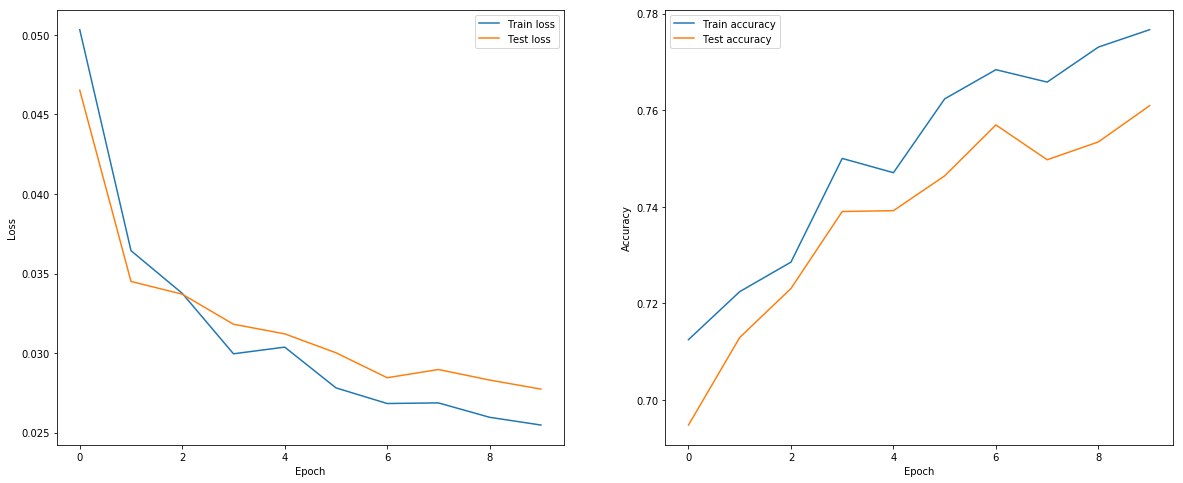

In [10]:
### BEGIN Solution
def train(model, optimizer, criterion, num_epochs=10, silent=False, model_name='_1_RNN_HotEncode'):
    print("Train examples: {}".format(len(trainset)))
    print("Validation examples: {}".format(len(testset)))
    print("Start training...")

    train_loss_plot = []
    test_loss_plot = []
    train_accur_plot = []
    test_accur_plot = []

    for epoch in range(num_epochs):
        if (not silent):
            print("Epoch {:2}: ".format(epoch), end='')
        else:
            print('.', end='')

        # train one epoch
        model.train()
        total_train_loss = 0
        correct_examples_train = 0
        for batch_idx, data in enumerate(trainloader):
            input, label = data
            if torch.cuda.is_available():
                input, label = input.cuda(), label.cuda()

            optimizer.zero_grad()
            
            hidden = torch.zeros((1, input.shape[0], n_hidden)).to(device)
            pred = model(input, hidden)  
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, pred_choice = F.softmax(pred, dim = 1).max(1)
            correct = pred_choice.eq(label).sum()
            correct_examples_train += correct.item()

        model.eval()
        correct_examples_test = 0
        total_test_loss = 0
        for batch_idx, data in enumerate(testloader):
            input, label = data
            if torch.cuda.is_available():
                input, label = input.cuda(), label.cuda()
            
            hidden = torch.zeros((1, input.shape[0], n_hidden)).to(device)
            pred = model(input, hidden)
            loss = criterion(pred, label)
            total_test_loss += loss.item()

            _, pred_choice = F.softmax(pred, dim = 1).max(1)
            correct = pred_choice.eq(label).sum()
            correct_examples_test += correct.item()

        torch.save(model.state_dict(), model_name + '_{}.pth'.format(epoch))
        
        if (not silent):
            print('Train loss {:6.3}, Test loss: {:6.3}, test accuracy = {:4.2f}'\
                  .format(total_train_loss / len(trainset), 
                          total_test_loss  / len(testset),
                          correct_examples_test / len(testset) / MAX_LEN))
        
        train_loss_plot.append(total_train_loss / len(trainset))
        test_loss_plot.append(total_test_loss  / len(testset))

        train_accur_plot.append(correct_examples_train / len(trainset) / MAX_LEN)
        test_accur_plot.append(correct_examples_test / len(testset) / MAX_LEN)

    plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.plot(range(num_epochs), train_loss_plot)
    plt.plot(range(num_epochs), test_loss_plot)
    plt.legend(['Train loss', 'Test loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(range(num_epochs), train_accur_plot)
    plt.plot(range(num_epochs), test_accur_plot)
    plt.legend(['Train accuracy', 'Test accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

train(rnn, optimizer, criterion, num_epochs=10) # RMSprop (default params)
### END Solution 

## Get activations

In [11]:
Wx, Wy, bx, by = rnn.get_params()
Wx.shape, Wy.shape, bx.shape, by.shape

(torch.Size([128, 92]),
 torch.Size([128, 128]),
 torch.Size([128]),
 torch.Size([128]))

In [223]:
def text2act(text):
    hidden = torch.zeros(n_hidden).to(device)
    output = np.empty((len(text), n_hidden))
    for i in range(len(text)):
        ch = text[i]
        hidden = torch.tanh(Wx.mv(letterToTensor(ch).float().to(device)) + bx + Wy.mv(hidden) + by)
        output[i] = hidden.cpu().detach().numpy()
    return output

In [224]:
# example text
print(test_text[idx])

Frenchie Nose Keychain, Frenchie Mom Gift, French Bulldog, Dog Lover Gift

This irresistible handmade keychain is here to brighten your day!

We all know that our furry friends express their love through their adorable wet noses! Give the gift of unconditional love or decorate your own keys with your pup&#39;s best feature! 

A fun gift for dog owners and dog lovers alike! Cute, cheeky and funny, these are the perfect addition to your keys! 

These are hand sculpted pieces, made from start to finish with care and tail wags. Thank you for supporting small businesses this holiday season.


This listing is for one pug keychain (please choose rope or loop keychain):

Nose: approx. 1 & 1/8&quot; H x 1 & 1/8&quot; W x 1/2&quot; D

Material: Resin


Follow Us! like us and see our newest products
• Instagram  
https://www.instagram.com/bestbeastie
• Facebook and Pinterest : VitruvianSculpture


See more of our work here:
https://www.etsy.com/shop/VitruvianSculpture


Copyright © 2018 Alex Aron

In [225]:
output = text2act(test_text[idx])

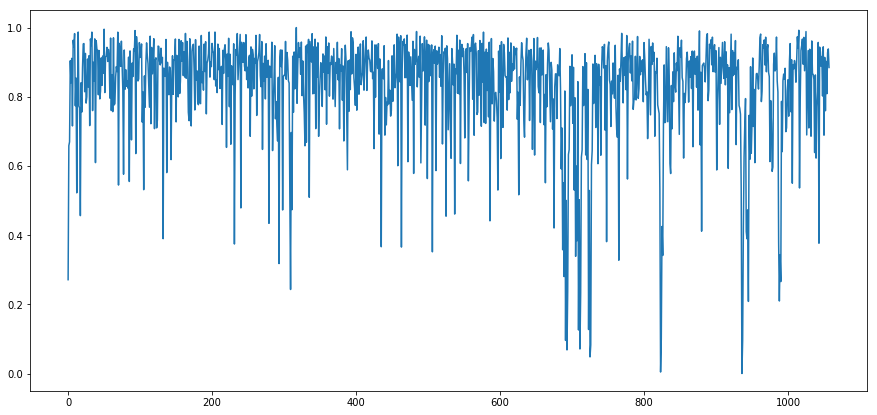

In [226]:
norm = col.Normalize()
plt.figure(figsize=(15, 7))
plt.plot(norm(output[:, 10]))
plt.show()

## Color patterns!

In [227]:
cmap = cm.get_cmap('Spectral')

def rgb_to_hex(rgb):
    rgb_int = tuple([int(255 * x) for x in rgb])
    return '%02x%02x%02x' % rgb_int


def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)


def text_pattern(neuron_idx):
    text_colors = []
    for i in range(len(test_text[idx])):
        text_colors.append(cstr(test_text[idx][i], color='#' + rgb_to_hex(cmap(norm(output[:, neuron_idx][i]))[:-1])))
    return html_print(cstr(''.join(text_colors), color='black') )

In [228]:
# some junk in text
text_pattern(19)

In [229]:
# vowels
text_pattern(38)

In [230]:
# websites
text_pattern(41)

In [231]:
# find smth interesting by yourself...
text_pattern(60)